# GAT with Mini-batch Training: Neighbour Sampling Technique

- Mini batches are created using `Neighbour Sampling` technique where this approach limits the sampling number of neighbours for a given particular target node.

Mini-batching is so useful it became standard in regular neural networks. However, it is not as straightforward with graph data, since splitting the dataset into smaller chunks would break essential connections between nodes

In [3]:
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch.nn import Linear, Dropout

# Loading the dataset
dataset = Planetoid(root='./data', name='Cora')
data = dataset[0]
print(data)

print('Graph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Graph:
------
Training nodes: 140
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


## Creating Mini-batches

In [47]:
from torch_geometric.loader import NeighborLoader

train_loader = NeighborLoader(data, num_neighbors=[10, 10], batch_size=16, input_nodes=data.train_mask,)

# Verifying the obtained subgraphs
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph: {i}: {subgraph}')

Subgraph: 0: Data(x=[201, 1433], edge_index=[2, 299], y=[201], train_mask=[201], val_mask=[201], test_mask=[201], batch_size=16)
Subgraph: 1: Data(x=[228, 1433], edge_index=[2, 341], y=[228], train_mask=[228], val_mask=[228], test_mask=[228], batch_size=16)
Subgraph: 2: Data(x=[263, 1433], edge_index=[2, 390], y=[263], train_mask=[263], val_mask=[263], test_mask=[263], batch_size=16)
Subgraph: 3: Data(x=[264, 1433], edge_index=[2, 380], y=[264], train_mask=[264], val_mask=[264], test_mask=[264], batch_size=16)
Subgraph: 4: Data(x=[268, 1433], edge_index=[2, 421], y=[268], train_mask=[268], val_mask=[268], test_mask=[268], batch_size=16)
Subgraph: 5: Data(x=[300, 1433], edge_index=[2, 489], y=[300], train_mask=[300], val_mask=[300], test_mask=[300], batch_size=16)
Subgraph: 6: Data(x=[237, 1433], edge_index=[2, 389], y=[237], train_mask=[237], val_mask=[237], test_mask=[237], batch_size=16)
Subgraph: 7: Data(x=[220, 1433], edge_index=[2, 360], y=[220], train_mask=[220], val_mask=[220], 

A batch_size to speed up the process by creating subgraphs for multiple target nodes. In this case, 16 of target nodes share the same subgraph! 

## Visualizing the created batches / subgraphs

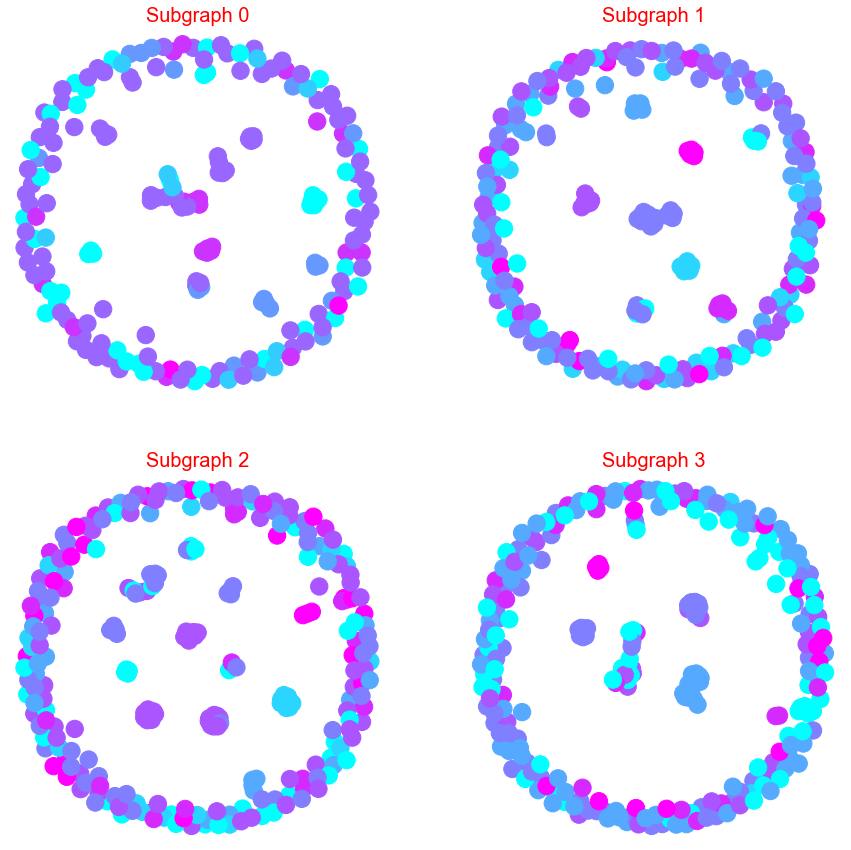

In [104]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

fig = plt.figure(figsize=(15, 15))

for idx, (subdata, pos) in enumerate(zip(train_loader ,[221, 222, 223, 224])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f'Subgraph {idx}', fontsize=20, color='red')
    plt.axis('off')
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=0), with_labels=False, node_color=subdata.y, cmap='cool')
plt.show()

In [2]:
#Accuracy function
def accuracy(y_pred, y_true):
    return torch.sum(y_pred == y_true) / len(y_true)


In [27]:
from tqdm import tqdm

class GAT(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h * heads, dim_out, heads=1)
        
    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return F.log_softmax(h, dim=1)
        
        
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=0.01)
        
        for epoch in tqdm(range(epochs+1)):
            total_loss, val_loss, acc, val_acc = 0, 0, 0, 0
            
            for batch in train_loader:
                optimizer.zero_grad()
                out = self(batch.x, batch.edge_index)
                
                loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
                total_loss += loss
                
                acc += accuracy(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
                loss.backward()
                optimizer.step()
                
                # Validation
                val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
                val_acc += accuracy(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])
                
            if epoch % 20 == 0:
                print(f'Epoch {epoch:>3} | Train Loss: {loss/len(train_loader):.3f} | Train Acc: {acc/len(train_loader) * 100:>6.2f}% | Val Loss: {val_loss/len(train_loader):.2f} | Val Acc: {val_acc/len(train_loader) * 100:.2f}%')
                
    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

In [48]:
gat = GAT(dataset.num_features, 32, dataset.num_classes)
print(gat)

GAT(
  (gat1): GATv2Conv(1433, 32, heads=8)
  (gat2): GATv2Conv(256, 7, heads=1)
)


In [49]:
gat.fit(data, epochs=500)

  0%|▏                                          | 2/501 [00:00<01:37,  5.12it/s]

Epoch   0 | Train Loss: 0.150 | Train Acc:  44.14% | Val Loss: 1.78 | Val Acc: 34.19%


  4%|█▊                                        | 22/501 [00:03<01:26,  5.55it/s]

Epoch  20 | Train Loss: 0.074 | Train Acc:  95.31% | Val Loss: 1.59 | Val Acc: 52.21%


  8%|███▌                                      | 42/501 [00:07<01:15,  6.09it/s]

Epoch  40 | Train Loss: 0.018 | Train Acc:  89.66% | Val Loss: 1.74 | Val Acc: 51.41%


 12%|█████▏                                    | 62/501 [00:10<01:16,  5.71it/s]

Epoch  60 | Train Loss: 0.026 | Train Acc:  91.40% | Val Loss: 1.58 | Val Acc: 52.45%


 16%|██████▊                                   | 82/501 [00:14<01:14,  5.64it/s]

Epoch  80 | Train Loss: 0.005 | Train Acc:  95.29% | Val Loss: 1.56 | Val Acc: 55.14%


 20%|████████▎                                | 102/501 [00:17<01:17,  5.17it/s]

Epoch 100 | Train Loss: 0.029 | Train Acc:  93.78% | Val Loss: 1.45 | Val Acc: 53.31%


 24%|█████████▉                               | 121/501 [00:22<01:59,  3.19it/s]

Epoch 120 | Train Loss: 0.026 | Train Acc:  91.71% | Val Loss: 1.59 | Val Acc: 51.42%


 28%|███████████▌                             | 141/501 [00:27<01:32,  3.89it/s]

Epoch 140 | Train Loss: 0.025 | Train Acc:  94.48% | Val Loss: 1.53 | Val Acc: 52.38%


 32%|█████████████▎                           | 162/501 [00:31<01:01,  5.55it/s]

Epoch 160 | Train Loss: 0.003 | Train Acc:  95.95% | Val Loss: 1.42 | Val Acc: 59.19%


 36%|██████████████▊                          | 181/501 [00:35<01:12,  4.41it/s]

Epoch 180 | Train Loss: 0.022 | Train Acc:  90.88% | Val Loss: 1.77 | Val Acc: 48.52%


 40%|████████████████▍                        | 201/501 [00:40<01:12,  4.15it/s]

Epoch 200 | Train Loss: 0.052 | Train Acc:  93.75% | Val Loss: 1.64 | Val Acc: 53.05%


 44%|██████████████████                       | 221/501 [00:45<01:01,  4.54it/s]

Epoch 220 | Train Loss: 0.022 | Train Acc:  93.89% | Val Loss: 1.57 | Val Acc: 52.19%


 48%|███████████████████▋                     | 241/501 [00:49<01:01,  4.20it/s]

Epoch 240 | Train Loss: 0.027 | Train Acc:  89.61% | Val Loss: 1.68 | Val Acc: 50.79%


 52%|█████████████████████▎                   | 261/501 [00:54<01:04,  3.75it/s]

Epoch 260 | Train Loss: 0.037 | Train Acc:  93.03% | Val Loss: 1.49 | Val Acc: 54.68%


 56%|██████████████████████▉                  | 281/501 [00:59<00:50,  4.39it/s]

Epoch 280 | Train Loss: 0.045 | Train Acc:  93.04% | Val Loss: 1.45 | Val Acc: 55.90%


 60%|████████████████████████▋                | 301/501 [01:04<00:42,  4.70it/s]

Epoch 300 | Train Loss: 0.022 | Train Acc:  93.14% | Val Loss: 1.52 | Val Acc: 56.17%


 64%|██████████████████████████▎              | 321/501 [01:08<00:36,  4.92it/s]

Epoch 320 | Train Loss: 0.017 | Train Acc:  96.01% | Val Loss: 1.62 | Val Acc: 50.64%


 68%|███████████████████████████▉             | 341/501 [01:12<00:32,  4.89it/s]

Epoch 340 | Train Loss: 0.021 | Train Acc:  92.50% | Val Loss: 1.54 | Val Acc: 52.60%


 72%|█████████████████████████████▌           | 362/501 [01:17<00:28,  4.91it/s]

Epoch 360 | Train Loss: 0.036 | Train Acc:  89.53% | Val Loss: 1.61 | Val Acc: 52.73%


 76%|███████████████████████████████▎         | 382/501 [01:21<00:23,  5.03it/s]

Epoch 380 | Train Loss: 0.023 | Train Acc:  92.36% | Val Loss: 1.64 | Val Acc: 50.04%


 80%|████████████████████████████████▊        | 401/501 [01:25<00:20,  4.97it/s]

Epoch 400 | Train Loss: 0.016 | Train Acc:  94.32% | Val Loss: 1.76 | Val Acc: 52.71%


 84%|██████████████████████████████████▌      | 422/501 [01:29<00:16,  4.91it/s]

Epoch 420 | Train Loss: 0.011 | Train Acc:  94.16% | Val Loss: 1.60 | Val Acc: 55.04%


 88%|████████████████████████████████████▏    | 442/501 [01:33<00:11,  5.08it/s]

Epoch 440 | Train Loss: 0.021 | Train Acc:  94.29% | Val Loss: 1.64 | Val Acc: 49.17%


 92%|█████████████████████████████████████▊   | 462/501 [01:37<00:07,  5.07it/s]

Epoch 460 | Train Loss: 0.014 | Train Acc:  95.46% | Val Loss: 1.52 | Val Acc: 55.14%


 96%|███████████████████████████████████████▍ | 482/501 [01:41<00:03,  5.21it/s]

Epoch 480 | Train Loss: 0.026 | Train Acc:  92.35% | Val Loss: 1.41 | Val Acc: 56.22%


100%|█████████████████████████████████████████| 501/501 [01:45<00:00,  4.76it/s]

Epoch 500 | Train Loss: 0.021 | Train Acc:  93.75% | Val Loss: 1.71 | Val Acc: 51.16%


In [50]:
acc = gat.test(data)
print(f'GAT test accuarcy: {acc * 100:.2f}%')

GAT test accuarcy: 78.60%


Batch size = 16, shows good testing accuracy, when it is compared to other sizes: 8, 32

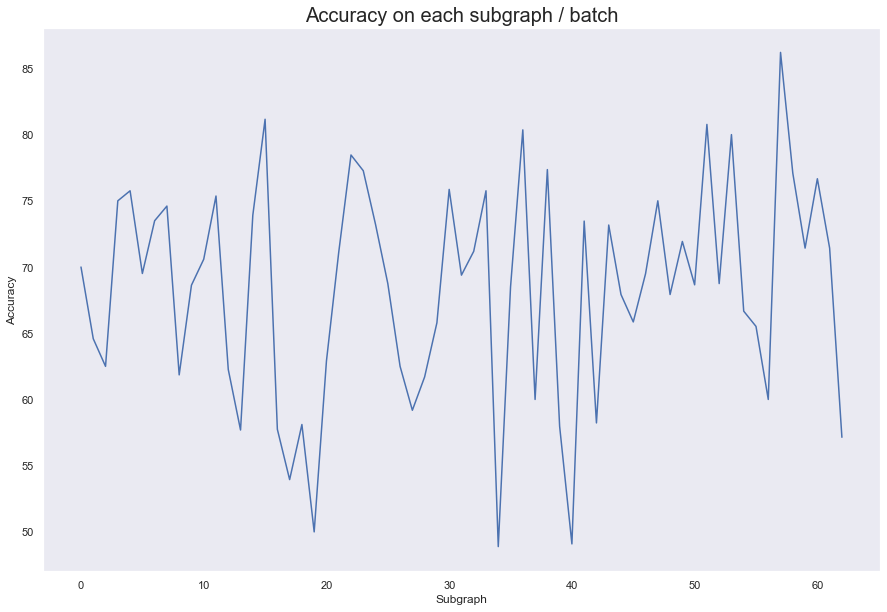

Average acc for whole graph 68.33754290664007
Accuracy for graph without using subgraphs:  78.60000133514404


In [108]:
# Creating subgraphps based on Neighbour sampling techniques for the test data
test_loader = NeighborLoader(data, num_neighbors=[10, 10], batch_size=16, input_nodes=data.test_mask,)

total_acc = 0
all_acc = []
subgraphs = []

for idx, subgraph in enumerate(test_loader):
    # print(subgraph)
    acc = gat.test(subgraph)
    total_acc += acc.item()
    all_acc.append(acc.item() * 100)
    subgraphs.append(idx)
    # print(f'{acc * 100:.2f}')

    
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


data_plot = pd.DataFrame({"Subgraph":subgraphs, "Accuracy":all_acc})

fig, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(x = "Subgraph", y = "Accuracy", data=data_plot, ax=ax)
sns.set(style='dark',)
ax.set_title('Accuracy on each subgraph / batch', fontsize=20)
plt.show()

print('Average acc for whole graph', total_acc/len(test_loader) * 100)
acc_w = gat.test(data)
print('Accuracy for graph without using subgraphs: ', acc_w.item() * 100)

In [103]:
print(data.test_mask.shape)
print(data.train_mask.shape)
print(data.val_mask.shape)

print('No of nodes in test mask',sum(data.test_mask).item())
print('No of nodes in train mask',sum(data.train_mask).item())
print('No of nodes in val mask',sum(data.val_mask).item())
# print(sum(data.y == 6).item())

torch.Size([2708])
torch.Size([2708])
torch.Size([2708])
No of nodes in test mask 1000
No of nodes in train mask 140
No of nodes in val mask 500
180
